# Traitement de la DATA

In [1]:

import torch.nn as nn
import torch.optim as optim
import os
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import spacy
import pandas as pd
from torch.utils.data import Subset
from torch.utils.data import random_split

spacy_tokenizer = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.itos = {
            0: "<PAD>",
            1: "<SOS>",
            2: "<EOS>",
            3: "<UNK>"
        }
        self.stoi = {
            "<PAD>": 0,
            "<SOS>": 1,
            "<EOS>": 2,
            "<UNK>": 3
        }
        self.freq_threshold = freq_threshold

    def tokenize(self, text):
        return [token.text.lower() for token in spacy_tokenizer.tokenizer(text)]

    def make_vocabulary(self, sequences):
        current_idx = 4
        frequencies = {}

        for sequence in sequences:
            for word in self.tokenize(sequence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = current_idx
                    self.itos[current_idx] = word
                    current_idx += 1

    def encode(self, text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

    def decode(self, sequence):
        return [self.itos[token] if token in self.itos else "<UNK>" for token in sequence]

    def __len__(self):
        return len(self.itos)


class CustomPKMNDataset(Dataset):
    """

    input : 
        img_dir   ->   str , emplacement image
        data_file ->   str , emplacement fichier csv 
        transform ->       , transformation appliquée aux images (Resize)
    
    return :

        Dataset   ->        , encodage images & légendes & types pokémons (tenseur torch)

    
    """
    def __init__(self, img_dir, data_file, transform=None):


        self.img_dir = img_dir                 
        self.data = pd.read_csv(data_file)
        self.sequence_max = self.data['caption'].apply(lambda x: len(x.split())).max() 
        self.transform = transform    
        self.vocab = Vocabulary()
        self.vocab.make_vocabulary(self.data['caption'])      # encodage des légendes 
        self.unique_types = self.data['type'].unique()        # nombre de type 
        self.type_to_int = {type: idx for idx, type in enumerate(self.unique_types)} # encodage des types
        self.int_to_type = {idx: type for type, idx in self.type_to_int.items()}

    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        ligne = self.data.iloc[idx]
        image_name = ligne['image']  

        img_path = os.path.join(self.img_dir, image_name)

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        caption = ligne['caption']
        pokemon_type = ligne['type']

        # Convertir la légende en indices
        legende = [1]+ self.vocab.encode(caption)[1:] +[2]   # ne pas prendre en compte l'espace initial : ' '
 
        add_padding =  dataset.sequence_max + 2 - len(legende)

        legende += [0]*add_padding


        # Encoder le type du Pokémon 
        type_encodage = self.type_to_int[pokemon_type]

        return image, torch.tensor(legende,dtype=torch.long), torch.tensor(type_encodage,dtype=torch.long)
    

class PaddingCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True,
                               padding_value=self.pad_idx)
        types = [item[2].unsqueeze(0) for item in batch]
        types = torch.cat(types, dim=0)
        return imgs, targets, types


def make_loader(img_dir, data_file, transform, batch_size=32, num_workers=0, shuffle=True, pin_memory=True):
    """

    return :  
        (train_loader, test_loader) -> utilisés pour entrainer le RNN

        train_all_laoder            -> utilisé pour entrainer le Resnet50
    
        
    """

    dataset = CustomPKMNDataset(
        img_dir, data_file, transform=transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle,
        pin_memory=pin_memory, collate_fn=PaddingCollate(pad_idx))
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle,
        pin_memory=pin_memory, collate_fn=PaddingCollate(pad_idx))

    train_all_loader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle,
        pin_memory=pin_memory, collate_fn=PaddingCollate(pad_idx))


    return train_all_loader , (train_loader,test_loader) , dataset


class InfiniteDataLoader:
    def __init__(self, dataset, batch_size=32, num_workers=0, shuffle=True, pin_memory=True):

        train_sampler = torch.utils.data.RandomSampler(
            dataset, replacement=True, num_samples=int(1e10))
            
        pad_idx = dataset.vocab.stoi["<PAD>"]

        self.train_loader = DataLoader(
            dataset, sampler=train_sampler, batch_size=batch_size, num_workers=num_workers,
        pin_memory=pin_memory, collate_fn=PaddingCollate(pad_idx))
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


img_dir = 'data/images/'
data_file = 'data/data.csv'


set_size = set()
def print_image_dimensions(img_dir):
    """
    
    set_size  -> ensemble des tailles d'images possibles

    
    """
    for img_filename in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_filename)
        with Image.open(img_path) as img:
             set_size.add(img.size[0])

print_image_dimensions(img_dir)

size_resnet = 224            # taille d'entrée des images de Resnet50
min_size  = min(set_size)    # taille minimale des images  du dataset
print(f"taille minimale des images  du dataset {min_size} , taille d'entrée des images de Resnet50 {size_resnet}")
print()


transform = transforms.Compose([      # transformation appliqué aux images -> shape(224,224) + tensor torch 
    transforms.Resize((size_resnet, size_resnet)),
    transforms.ToTensor()
])


train_all_loader , (train_loader,test_loader) , dataset= make_loader(img_dir , data_file ,transform ) # entrainement CNN

batch_loader = InfiniteDataLoader(dataset)   # entrainement RNN

images, legendes, types = next(iter(train_all_loader))

print(f"taille des batchs d'images {images.shape}")
print()
print(f'taille des batchs légendes {legendes.shape}')
print()
print(f'taille des batchs types {types.shape}')



taille minimale des images  du dataset 272 , taille d'entrée des images de Resnet50 224

taille des batchs d'images torch.Size([32, 3, 224, 224])

taille des batchs légendes torch.Size([32, 18])

taille des batchs types torch.Size([32])


## Creation du modèle Resnet 50

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class IdentityBlock(nn.Module):
    def __init__(self, in_channels, filters, dropout_rate=0.3):
        super(IdentityBlock, self).__init__()
        f1, f2, f3 = filters

        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels, f1, kernel_size=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),

            nn.Conv2d(f1, f2, kernel_size=3, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),

            nn.Conv2d(f2, f3, kernel_size=1),
            nn.BatchNorm2d(f3)
        ])

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = x

        for layer in self.layers:
            x = layer(x)

        x = self.dropout(x)
        x += identity
        x = F.relu(x)
        return x
    
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, filters, kernel_size, stride=2,  dropout_rate=0.3):
        super(ConvolutionalBlock, self).__init__()
        f1, f2, f3 = filters

        self.main_layers = nn.ModuleList([
            nn.Conv2d(in_channels, f1, kernel_size=1, stride=stride),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),

            nn.Conv2d(f1, f2, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),

            nn.Conv2d(f2, f3, kernel_size=1),
            nn.BatchNorm2d(f3)
        ])

        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, f3, kernel_size=1, stride=stride),
            nn.BatchNorm2d(f3)
        )

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = self.shortcut(x)

        for layer in self.main_layers:
            x = layer(x)

        x = self.dropout(x)
        x += identity
        x = F.relu(x)
        return x


class ResNet50(nn.Module):
    def __init__(self,num_classes,layers=[2,3], dropout_rate=0.0):
        super(ResNet50, self).__init__()
        self.dropout_rate = dropout_rate
        # Initialiser les couches et les blocs
        self.layers = [
            nn.ZeroPad2d(3),
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ]

        # Ajouter les couches de ResNet50
        self.layers += self._make_layer(64, [64, 64, 256], layers[0], stride=1)
        self.layers += self._make_layer(256, [128, 128, 512], layers[1], stride=2)
        #self.layers += self._make_layer(512, [256, 256, 1024], layers[2], stride=2)
        #self.layers += self._make_layer(1024, [512, 512, 2048], layers[3], stride=2)

        # Ajouter la couche fully connected
        self.layers += [
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        ]

        # Créer le modèle séquentiel
        self.model = nn.Sequential(*self.layers)


    def _make_layer(self, in_channels, filters, blocks, stride):
        layers = []
        layers.append(ConvolutionalBlock(in_channels, filters, kernel_size=3, stride=stride, dropout_rate=self.dropout_rate))
        for _ in range(1, blocks):
            layers.append(IdentityBlock(filters[2], filters, self.dropout_rate))
        return nn.Sequential(*layers)

    def freeze_initial_layers(self,ind=2):
        # methode pour eviter l'overfeating (freeze les poids de certaines couches)
        # Geler les premières couches.
        for layer in self.model[:ind]:  
            for param in layer.parameters():
                param.requires_grad = False


    def forward(self, x, return_intermediate = False):    
        # permet de sortir les vecteurs avant leur passage dans la couche Fully connected 
        
        
        for layer in self.model[:-2]:
            x = layer(x)
        
        if return_intermediate:
            
            return x
        else:
            
            for layer in self.model[-2:]:
                x = layer(x)
            return x

    
num_classes = len(dataset.unique_types)

cnn_model = ResNet50(num_classes)
#cnn_model.freeze_initial_layers()   

output = cnn_model(images)
print(f'taille de sortie {output.shape}')
print()
print(f'taille attendu {types.shape}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print()
print(device)
print()


model_path = 'model_cnn.pth'
find_model = True
if os.path.isfile(model_path):
    cnn_model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu') ))
    print("Modèle chargé avec succès.")
else:
    print("Fichier modèle non trouvé.")
    find_model = False


cnn_model.to(device)

taille de sortie torch.Size([32, 18])

taille attendu torch.Size([32])

cpu

Modèle chargé avec succès.


ResNet50(
  (model): Sequential(
    (0): ZeroPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): ConvolutionalBlock(
      (main_layers): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): 

In [3]:
num_epochs = 200
lr = 1e-4
loss_function = nn.CrossEntropyLoss()
weight_decay = 0.00

# optimiseur avec la régularisation L2 pour une meilleure généralisation 
optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=weight_decay)

# en raison d'overfeating j'ai décidé de ne pas faire de test_laoder sur la partie CNN 

# Entrainement CNN

In [4]:
if not find_model :
    for epoch in range(num_epochs):
        
        avg_train_loss = 0
        correct = 0
        total = 0
        for batch_idx , (images, _, types) in enumerate(train_all_loader): 
            cnn_model.train(True)
            optimizer.zero_grad()
            outputs = cnn_model(images.to(device))
            loss = loss_function(outputs, types.to(device).long())
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item()
            cnn_model.train(False)
            with torch.no_grad():
                _, predicted = torch.max(F.softmax(outputs).data, 1)
                total += types.size(0)
                correct += (predicted == types.to(device)).sum().item()

        avg_train_loss /= batch_idx+1
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f} , Accuracy : {(100 * correct / total):.2f} % ')
        print()

        if epoch % 10 ==9 :
            # save le model
            torch.save(cnn_model.state_dict(), 'model_cnn.pth')

        if abs(1 -correct / total )<1e-3:
             break




In [5]:
# test shape
output = cnn_model(images.to(device),True).squeeze([2,3])
print(f'taille de sortie {output.shape}')
print()
print(f'taille attendu {types.shape}')

taille de sortie torch.Size([32, 512])

taille attendu torch.Size([32])


# Creation du Modèle RNN et Combined CNN-RNN

# Methode avec LSTM  1 couches

In [12]:

class LSTM(nn.Module):
    def __init__(self, vocab_size, hdim, input_cnn_size, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        super(LSTM, self).__init__()


        self.embedding = nn.Embedding(vocab_size, hdim)
        self.lstm = nn.LSTM(input_size=hdim , hidden_size=hdim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hdim , vocab_size)  
        #self.linear_input = nn.Linear(input_cnn_size, hdim)
        self.bn = nn.BatchNorm1d(hdim)  
        self.device = device
        self.to(device)

    def forward(self, x, images_output, generation=False):
        embedding_image = images_output#self.linear_input(images_output)
        if not generation:
            x = self.embedding(x[:, :-1])
        else:
            x = self.embedding(x)
        
        x = x + embedding_image.unsqueeze(1)


        x = x.to(self.device)

        lstm_out, (h,_) = self.lstm(x)
        

        # Passage à travers la couche linéaire
        out = self.linear(lstm_out)
        if generation : 
            return self.linear(h)
        return out  


class Combined_cnn_LSTM(nn.Module):
    def __init__(self,cnn_model , vocab_size , hdim  ,  input_ccn_size ):
        super(Combined_cnn_LSTM, self).__init__()
        self.cnn_model = cnn_model
        self.vocab_size = vocab_size
        self.hdim = hdim
        self.input_ccn_size = input_ccn_size
        self.linear = nn.Linear(input_ccn_size,input_ccn_size)

        for param in self.cnn_model.parameters():
            param.requires_grad = False
              
        self.lstm_model = LSTM(vocab_size =self.vocab_size ,
                                 hdim=self.hdim ,
                                 input_cnn_size = self.input_ccn_size)

    def forward(self, caption,images, generation =False ):
        output_cnn = self.cnn_model(images,True).squeeze([2,3])
        output_cnn = self.linear(output_cnn)
        output = self.lstm_model(caption,output_cnn , generation)  

        return output


images, captions, types = next(iter(train_loader))


output = cnn_model(images.to(device),True).squeeze([2,3])
_ , input_ccn_size =  output.shape         # taille de l'embedding de position de l'image (compréhension de l'image par le cnn)
hdim = 512
vocab_size = len(dataset.vocab)

print(f"taille du vocabulaire :  {vocab_size} ")
print()
print( f"dimesion caché : {hdim} ")
print()
print( f"taille de l'embedding de position par image :{input_ccn_size}")
print()
print("--------------------------------------------------------")
print()
model =Combined_cnn_LSTM(cnn_model = cnn_model,vocab_size =vocab_size ,hdim=hdim  ,input_ccn_size =  input_ccn_size)
model.to(device)


model.lstm_model.load_state_dict(torch.load('model_combined_LSTM_understand_2.pth',map_location=torch.device('cpu')))

output = model(captions.to(device),images.to(device))

print(f'taille de sortie {output.shape}')
print()
print(f'taille attendu {captions[:,1:].shape}')
print()
print(f'modif de la taille pour CrossEntropy :')
print()
print(f'    |   output : {output.view(-1, output.size(-1)).shape} ')
print(f'    |   légende : {captions[:,1:].reshape(-1).shape} ')

taille du vocabulaire :  229 

dimesion caché : 512 

taille de l'embedding de position par image :512

--------------------------------------------------------

taille de sortie torch.Size([32, 17, 229])

taille attendu torch.Size([32, 17])

modif de la taille pour CrossEntropy :

    |   output : torch.Size([544, 229]) 
    |   légende : torch.Size([544]) 


In [13]:
lr = 3e-4
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
import numpy as np
import random

@torch.no_grad()
def generate(rnn, ixs,image,dataset):


    for _ in range(dataset.sequence_max + 2):
        ix_cond = ixs 
        logits = rnn(ix_cond,image , True ).squeeze(1)[-1:]
        probs = F.softmax(logits, dim=-1)
        _, max_indices = torch.max(probs, dim=-1)
        ixs = torch.cat((ixs,max_indices.unsqueeze(-1) ), dim = -1)

    return ixs

@torch.no_grad()
def print_samples(rnn, dataset, device):
    
    X_init = torch.zeros(1, 1, dtype=torch.long).to(device) +1


    #  Sélectionner un entier au hasard entre 0 et len(dataset.data) - 1
    random_index = random.randint(0, len(dataset.data) - 1)

    image , legende = dataset.__getitem__(random_index)[0].to(device).unsqueeze(0) , dataset.__getitem__(random_index)[1]
    X_samp = generate(rnn, X_init,image, dataset)

    
    X_samp = np.array(X_samp.cpu())
    value  = dataset.vocab.decode(X_samp[0])
    res = dataset.vocab.decode(np.array(legende.cpu())[1:-1])

    def complet_sentence(liste):
        sentence = []
        for word in liste :
            if (word == '<EOS>') | (word == '<PAD>'):
                break 
            sentence.append(word)  
        
        return sentence

    sentence = complet_sentence(value)
    objetif =complet_sentence(res)


    
    # afficher l'image 
    ligne = dataset.data.iloc[random_index]
    image_name = ligne['image']  
    img_path = os.path.join(img_dir, image_name)
    image = Image.open(img_path)
    new_size = (100, 100) # par exemple, 100x100 pixels
    resized_image = image.resize(new_size)


    print('-----------------------------------------------')

    print(f"Image : {image_name} ")
    display(resized_image)
    print("Resultats :")
    print()
    print(' '.join(sentence[1:]))
    print()
    print("Objetif : ")
    print()
    print(' '.join(objetif))
    

    print('-----------------------------------------------')


-----------------------------------------------
Image : 174.png 


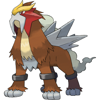

Resultats :

a brown flying creature with elephant with elephant yellow butterfly on top of it

Objetif : 

a very cute looking bird with big wings
-----------------------------------------------


In [15]:
print_samples(model , dataset, device)

/var/folders/fp/hfmjvl7d45gft5_1gf2dzn640000gn/T/ipykernel_41563/2807083808.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(logits.view(-1, logits.size(-1))).data, 1)


step 0 | loss 2.2693 | Accuracy : 58.64 %
step 10 | loss 0.7992 | Accuracy : 79.61 %
step 20 | loss 0.5173 | Accuracy : 82.96 %
step 30 | loss 0.4598 | Accuracy : 85.53 %
step 40 | loss 0.3367 | Accuracy : 87.41 %
step 50 | loss 0.3688 | Accuracy : 88.66 %
step 60 | loss 0.2707 | Accuracy : 89.74 %
step 70 | loss 0.2300 | Accuracy : 90.28 %
step 80 | loss 0.2196 | Accuracy : 91.49 %
step 90 | loss 0.2204 | Accuracy : 91.93 %
step 100 | loss 0.2331 | Accuracy : 92.10 %
step 110 | loss 0.2004 | Accuracy : 92.70 %
step 120 | loss 0.1896 | Accuracy : 93.46 %
step 130 | loss 0.1982 | Accuracy : 93.33 %
step 140 | loss 0.1831 | Accuracy : 94.14 %
step 150 | loss 0.2012 | Accuracy : 93.95 %
step 160 | loss 0.1412 | Accuracy : 95.02 %
step 170 | loss 0.1640 | Accuracy : 95.06 %
step 180 | loss 0.1255 | Accuracy : 95.22 %
step 190 | loss 0.1250 | Accuracy : 95.44 %
step 200 | loss 0.1000 | Accuracy : 95.70 %
-----------------------------------------------
Image : 662.png 


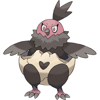

Resultats :

a drawing of a pokemon pokemon with blue eyes

Objetif : 

a pokemon ball with a bird on top of it
-----------------------------------------------
step 210 | loss 0.1549 | Accuracy : 95.28 %
step 220 | loss 0.1255 | Accuracy : 95.77 %


[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [16]:
step = 0 
correct = 0
total = 0
while True:
    images, legende, _ = batch_loader.next()
    
    images, legende = images.to(device), legende.to(device)

    model.train(True)
    logits = model(legende,images)    

    loss = loss_function(
        logits.view(-1, logits.size(-1)),
        legende[:,1:].reshape(-1)
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    cnn_model.train(False)
    with torch.no_grad():
        _, predicted = torch.max(F.softmax(logits.view(-1, logits.size(-1))).data, 1)
        total += legende[:,1:].reshape(-1).size(0)
        correct += (predicted == legende[:,1:].reshape(-1)).sum().item()

    
    if step % 10 == 0:
        print(f"step {step} | loss {loss.item():.4f} | Accuracy : {(100 * correct / total):.2f} %")
        correct = 0
        total = 0
    if step > 0 and step % 200 == 0:
        #print_samples(10, rnn, train_dataset, device)
        print_samples(model , dataset, device)
        torch.save(model.lstm_model.state_dict(), 'model_combined_LSTM_understand_2.pth')

    if step > 0 and step % 500 == 0:
        pass
        #train_loss = eval(rnn, train_dataset, batch_size, 10, criterion)
        #test_loss = eval(rnn, test_dataset, batch_size, 10, criterion)
        #print(f"step {step} train loss: {train_loss} test loss: {test_loss}")

    step += 1